In [1]:
using AutomotiveSensors

In [2]:
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using POMDPs
using Reel

In [3]:
rng = MersenneTwister(1)
cam = StaticCamera(VecE2(0., -8.), 16.0);

## Test Environment

In [4]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);
pomdp = UrbanPOMDP(env=env,
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.7, 
                   ped_birth=0.3, 
                   obstacles=true, # no fixed obstacles
                   lidar=false,
                   pos_obs_noise = 0., # fully observable
                   vel_obs_noise = 0.,
                   ego_start=20,
                   ΔT=0.1);

## Visualize Sensor Measurements

In [5]:
sensor = NoisySensor()

AutomotiveSensors.NoisySensor{AutomotiveSensors.LinearNoise,AutomotiveSensors.LinearNoise}
  pos_noise: AutomotiveSensors.LinearNoise
  vel_noise: AutomotiveSensors.LinearNoise
  false_positive_rate: Float64 0.1
  false_negative_rate: Float64 0.1
  rng: MersenneTwister


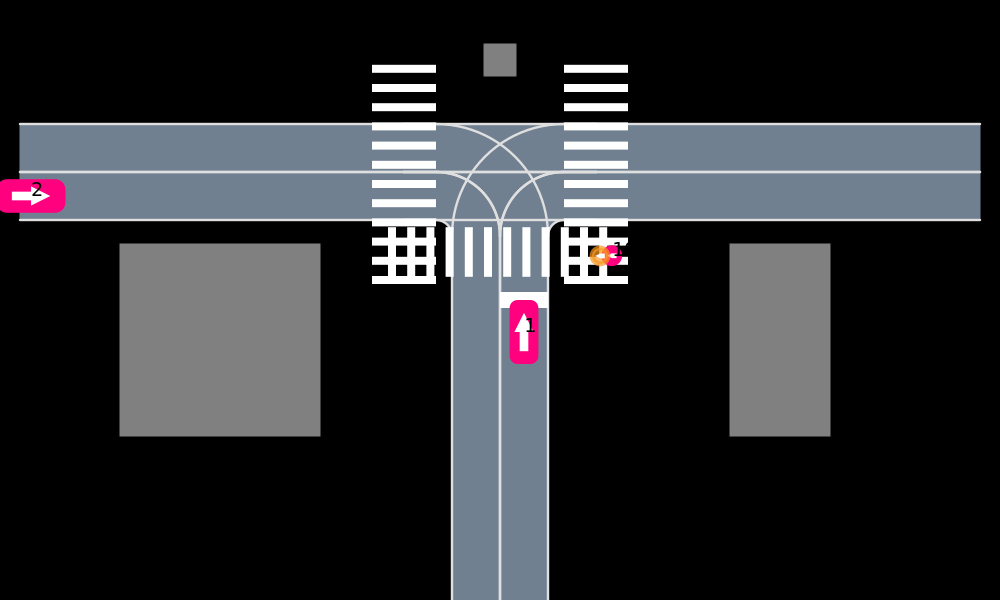

In [6]:
s0 = initial_state(pomdp, rng)
ego = get_ego(s0)
o = measure(sensor, ego, s0, env)
overlay = NoisySensorOverlay(sensor=sensor, o=o)
render(s0, pomdp.env, [overlay, IDOverlay()], cam=cam)

## State Estimator

In [7]:
using PedCar

In [8]:
using ParticleFilters

In [9]:
update_freq = 0.1
const N_PARTICLES = 2000

2000

In [10]:
mdp = PedCarMDP(env=env, pos_res=2.0, vel_res=2., ped_birth=0., car_birth=0.3, ΔT = update_freq);
init_transition!(mdp)
car_model = CarStateEstimator(mdp, 2, ego, sensor)
ped_model = PedStateEstimator(mdp, 101, ego, sensor)
# particle filter for each vehicles
car_filter = SimpleParticleFilter(car_model, LowVarianceResampler(N_PARTICLES));
ped_filter = SimpleParticleFilter(ped_model, LowVarianceResampler(N_PARTICLES));

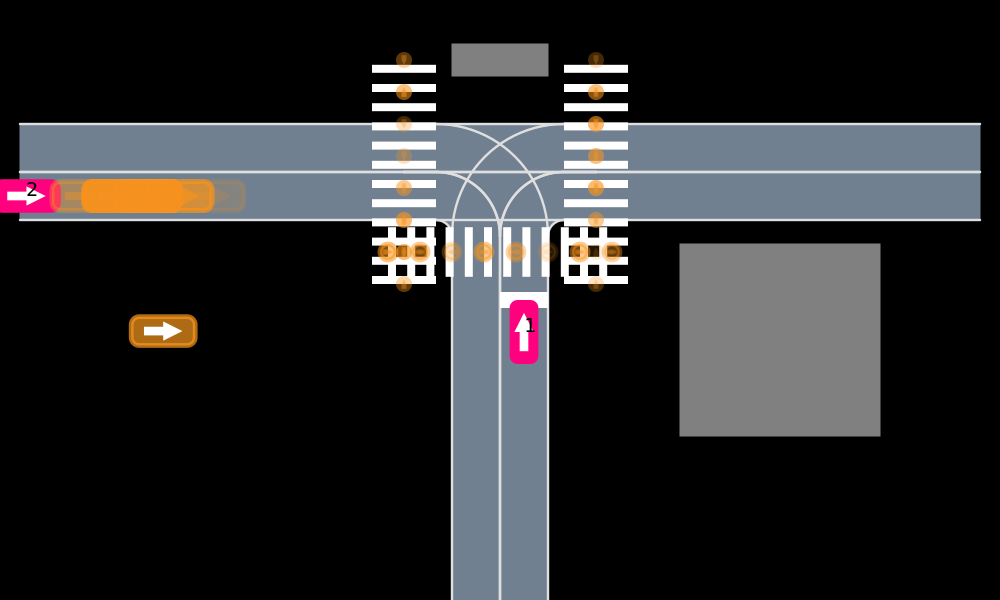

In [11]:
car_b0 = init_car_belief(car_model.mdp, N_PARTICLES, rng);
ped_b0 = init_ped_belief(ped_model.mdp, N_PARTICLES, rng)
s0 = initial_state(pomdp, rng)
ego = get_ego(s0)
car_filter.model.ego = ego
ped_filter.model.ego = ego
o = measure(sensor, ego, s0, env)
ped_b = update(ped_filter, ped_b0, o)
car_b = update(car_filter, car_b0, o);
obs_overlay = NoisySensorOverlay(sensor=sensor, o=o)
car_belief_overlay = ParticleOverlay(mdp=car_model.mdp, b=car_b)
ped_belief_overlay = ParticleOverlay(mdp=ped_model.mdp, b=ped_b)
render(s0, pomdp.env, [obs_overlay, car_belief_overlay, ped_belief_overlay, IDOverlay()], cam=StaticCamera(VecE2(0., -8.), 16.0))

In [26]:
n_steps = 100 
scene_hist = Vector{Scene}()
car_belief_hist = Vector{ParticleCollection{CarState}}()
ped_belief_hist = Vector{ParticleCollection{VehicleState}}()
obs_hist = Vector{Vector{Vehicle}}()

s = initial_state(pomdp, rng)
car_b = init_car_belief(car_model.mdp, N_PARTICLES, rng);
ped_b = init_ped_belief(ped_model.mdp, N_PARTICLES, rng)


push!(scene_hist,deepcopy(s))
push!(car_belief_hist,deepcopy(car_b))
push!(ped_belief_hist,deepcopy(ped_b))
for i=1:n_steps
    ego = get_ego(s)
    car_filter.model.ego = ego
    ped_filter.model.ego = ego
    o = measure(sensor, ego, s, env)
    @profile ped_b = update(ped_filter, ped_b, o)
    car_b = update(car_filter, car_b, o);
    s = generate_s(pomdp, s, UrbanAction(0.), rng)
    push!(obs_hist, deepcopy(o))
    push!(scene_hist, deepcopy(s))
    push!(car_belief_hist,deepcopy(car_b))
    push!(ped_belief_hist,deepcopy(ped_b))   
end

In [27]:
duration, fps, render_hist = animate_scenes(scene_hist, obs_hist, car_belief_hist, ped_belief_hist, mdp, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpRcAV0i", 0x0000000000000065, 10.0, nothing)

In [16]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene},
                        observations::Vector{Vector{Vehicle}},
                        car_beliefs::Vector{ParticleCollection{CarState}},
                        ped_beliefs::Vector{ParticleCollection{VehicleState}},
                        mdp;
                        cam=StaticCamera(VecE2(0., -8.), 16.0),
                        sim_dt=0.1)
    env = mdp.env
    duration =length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[IDOverlay()]
        if frame_index > 1
            obs_overlay = NoisySensorOverlay(sensor=sensor, o=observations[frame_index-1], color=MONOKAI["color2"])
            push!(overlays, obs_overlay)            
        end
        car_belief_overlay = ParticleOverlay(mdp=mdp, b=car_beliefs[frame_index])
        ped_belief_overlay = ParticleOverlay(mdp=mdp, b=ped_beliefs[frame_index])
        push!(overlays, car_belief_overlay)
        push!(overlays, ped_belief_overlay)
        return AutoViz.render(scenes[frame_index],
                              env,
                              overlays,
                              cam=cam,
                              car_colors=get_colors(scenes[frame_index]))
    end
    return duration, fps, render_rec
end


In [97]:
using ProfileView

14-Aug 18:41:20:WARNING:root:The profile data buffer is full; profiling probably terminated
before your program finished. To profile for longer runs, call Profile.init
with a larger buffer and/or larger delay.


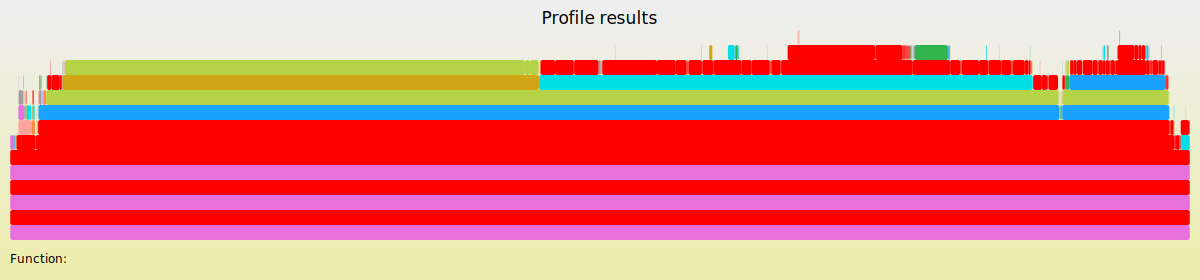

In [69]:
ProfileView.view()